In [1]:
from ml_mlp import MLP_Model
from ml_mlp import Linear_Model
from ml_mlp import MLP_Win_Model
from ml_mlp import LSTM_Model
import resources
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import multiprocessing
multiprocessing.set_start_method("spawn")

In [2]:
%matplotlib inline

# Pre-process data 
Load in feature datasets, remove wear in phase and combine.

In [3]:
exp5 = resources.load('Test 5')
exp7 = resources.load('Test 7')
exp8 = resources.load('Test 8')
exp9 = resources.load('Test 9')

In [4]:
dfs = [exp5.features.drop([23, 24]), exp7.features, exp8.features, exp9.features]
main_df = pd.concat(dfs)
main_df = main_df.drop(columns=['Runout', 'Form error', 'Peak radius', 'Radius diff']).drop([0, 1, 2, 3])
main_df.reset_index(drop=True, inplace=True)

In [5]:
print(f'Main df : {main_df.shape[0]} rows x {main_df.shape[1]} cols')
main_df.head()

Main df : 692 rows x 8 cols


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius
0,2.114221,7.972116,22.575564,-0.037290,46.668332,75.681806,42.884298,0.673830
1,2.231453,7.937418,20.322581,-0.030997,47.223830,76.327769,43.081297,0.672418
2,2.218086,8.176863,21.918605,-0.013387,47.121927,76.566675,42.880229,0.672192
3,2.288784,7.950098,19.731200,-0.023563,47.644655,76.725483,43.181153,0.672081
4,2.297028,8.107973,22.351243,-0.014962,47.152297,76.585970,43.056571,0.671812


In [8]:
def pred_plot(y: np.ndarray, y_pred: np.ndarray, title:str = ''):
    fig, ax = plt.subplots(1, 2)
    ax[0].scatter(y, y_pred)

    # limits of max radius
    # xmax = main_df['Mean radius'].values.max()
    # xmin = main_df['Mean radius'].values.min()
    xmax = 0.68
    xmin = 0.6
    

    ax[0].set_xlim([xmin, xmax])
    ax[0].set_ylim([xmin, xmax])

    lims = [
        np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()]),
    ]

    ax[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel('Actual Y / mm')
    ax[0].set_ylabel('Predicted Y /mm')
    ax[0].set_title(f'{title} - Predictions');
    
    diff = (y - y_pred)*1000

    ax[1].hist(diff, bins=30)
    ax[1].set_xlabel('Prediction Error / um')
    ax[1].set_ylabel('No Occurances')
    ax[1].set_title(f'{title} - Histogram');

    fig.tight_layout()


## MLP

In [12]:
mlp_reg = MLP_Model(feature_df=main_df,
                    target='Mean radius',
                    tb=False,
                    tb_logdir='tmux-test',
                    params={'loss': 'mse',
                            'no_layers': 3,
                            'no_nodes': 128,
                            'epochs': 2000,
                            'dropout': 0.01,
                            'batch_size': 20,
                            'init_mode': 'glorot_uniform',
                            }
                   )

-----------------------------------------------------------------
MLP-E-2000-B-20-L[128 128 128]-D-0.01-20230113-162641


Training:   0%|                                                    0/2000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.731 um
MSE = 1.530 um^2
R^2 = 0.987


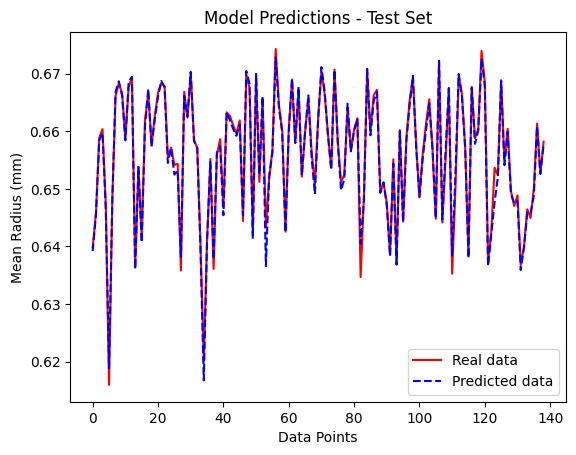

In [15]:
# mlp_reg.cv(n_splits=10, n_repeats=10)
mlp_reg.fit(validation_split=0.1, verbose=0)
mlp_reg.score(plot_fig=True);


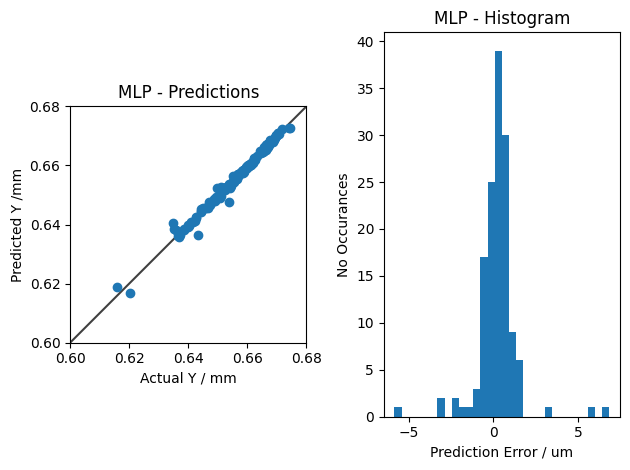

In [17]:
y = mlp_reg.val_data[1].values
y_pred = mlp_reg.model.predict(mlp_reg.val_data[0].values, verbose=0)
pred_plot(y, y_pred, 'MLP')

## MLP with Window

In [38]:
mlp_win_reg = MLP_Win_Model(feature_df=main_df,
                            target='Mean radius',
                            tb=False,
                            tb_logdir='tmux-test',
                            params={'seq_len': 5,
                                    'loss': 'mse',
                                    'epochs': 2000,
                                    'no_nodes': 128,
                                    'no_layers': 3,
                                    'batch_size': 20,
                                    'init_mode': 'glorot_uniform',
                                    'dropout': 0.01,
                                    },
                            )

-----------------------------------------------------------------
MLP_Win-WLEN-5-E-2000-B-20-L-[128 128 128]-D-0.01-20230113-172534


Training:   0%|                                                    0/2000 ETA: ?s,  ?epochs/s

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.993 um
MSE = 14.550 um^2
R^2 = 0.854


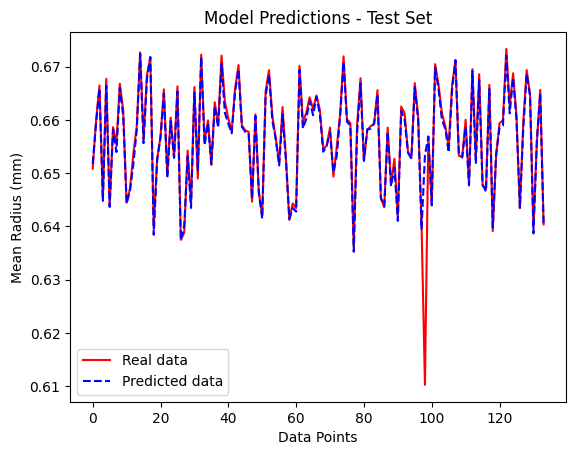

In [39]:
# mlp_win_reg.cv(n_splits=10, n_repeats=10)
mlp_win_reg.fit(validation_split=0.2, verbose=0)
mlp_win_reg.score(plot_fig=True);

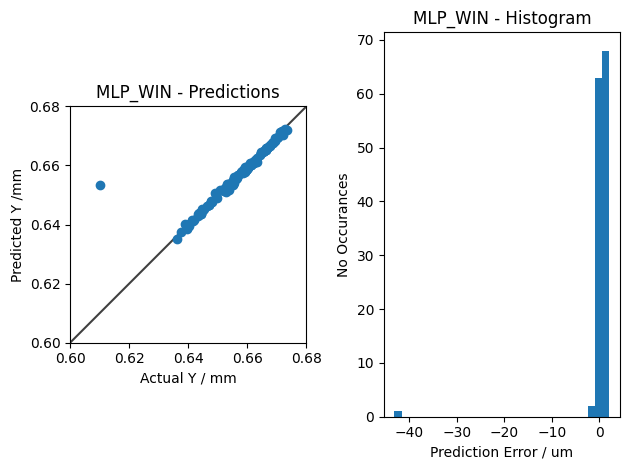

In [40]:
y = mlp_win_reg.val_data[1]
y_pred = mlp_win_reg.model.predict(mlp_win_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'MLP_WIN')

## LSTM

In [ ]:
lstm_reg = LSTM_Model(feature_df=main_df,
                      target='Mean radius',
                      tb=False,
                      tb_logdir='tmux-test',
                      params={'seq_len': 10,
                              'loss': 'mae',
                              'epochs': 100,
                              'no_layers': 3,
                              'no_dense': 1,
                              'no_nodes': 64,
                              }
                        )

In [ ]:
lstm_reg.cv(n_splits=10, n_repeats=10)
lstm_reg.fit(validation_split=0.2, verbose=0)
lstm_reg.score(plot_fig=True);

In [ ]:
y = lstm_reg.val_data[1]
y_pred = lstm_reg.model.predict(lstm_reg.val_data[0], verbose=0)
pred_plot(y, y_pred, 'LSTM')

## Linear Model

In [ ]:
lin_reg = Linear_Model(feature_df=main_df, target='Mean radius')

## MLP with window:

## LSTM:

In [ ]:
lstm_reg.cv(n_splits=10, n_repeats=10)
lstm_reg.fit(validation_split=0.2, verbose=0)
lstm_reg.score(plot_fig=True)

## Linear:

In [ ]:
lin_reg.fit()
lin_reg.score(plot_fig=False);

In [ ]:
y = lin_reg.val_data[1].values
y_pred = lin_reg.model.predict(lin_reg.val_data[0].values)
pred_plot(y, y_pred, 'Linear')